In [1]:
#Activation of the libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import openseespy.opensees as ops
import opsvis as opsv
import time

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 0.0214377 (max: 1e-06)
	Norm deltaX: 0.0241245, Norm R: 1.90838
	deltaX: -0.00117021 -0.0240961 
	deltaR: -0.780592 -1.74143 
CTestEnergyIncr::test() - iteration: 2 current EnergyIncr: 0.000779258 (max: 1e-06)
	Norm deltaX: 0.0045308, Norm R: 0.374704
	deltaX: -0.00012704 -0.00452902 
	deltaR: -0.158177 -0.339681 
CTestEnergyIncr::test() - iteration: 3 current EnergyIncr: 2.929e-05 (max: 1e-06)
	Norm deltaX: 0.000872382, Norm R: 0.0728134
	deltaX: -2.98761e-05 -0.00087187 
	deltaR: -0.0304389 -0.0661458 
CTestEnergyIncr::test() - iteration: 4 current EnergyIncr: 1.10711e-06 (max: 1e-06)
	Norm deltaX: 0.000169557, Norm R: 0.0141732
	deltaX: -5.59736e-06 -0.000169465 
	deltaR: -0.00593666 -0.0128699 
CTestEnergyIncr::test() - iteration: 5 current EnergyIncr: 4.18937e-08 (max: 1e-06)
	Norm deltaX: 3.29731e-05, Norm R: 0.00275718
	deltaX: -1.10041e-06 -3.29547e-05 
	deltaR: -0.00115423 -0.00250396 

CTestEnergyIncr::test() - iterat

[[ 0.00000000e+00  0.00000000e+00]
 [ 2.22552390e-02  4.04524071e+01]
 [ 3.85384167e-02  6.65649869e+01]
 [ 4.42530292e-02  8.01875408e+01]
 [ 3.80094227e-02  9.41363966e+01]
 [ 2.13238508e-02  1.20946103e+02]
 [-1.05588235e-03  1.61918606e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2.11496734e+02]
 [-2.52045167e-02  2

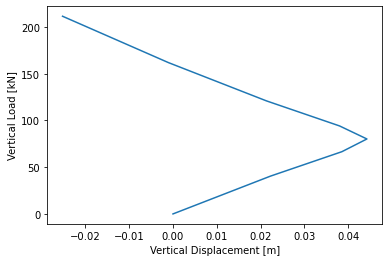

Running Time:  1.625694751739502  seconds


In [2]:
# Define the model
ops.wipe()
start = time.time()
### model('basic', '-ndm', ndm, '-ndf', ndf=ndm*(ndm+1)/2)
ops.model('basic', '-ndm', 2, '-ndf', 2)


ArcLengthAlpha = 0.38 #Initial value of alpha (arc length parameter)
ArcLengthLambda = 0.18  #Initial value of lambda (arc length parameter)
spring_stiffness = 79.924


#Geometric and material properties
E1 = 400000  # Modulus of elasticity in kN/m^2
A1 = 0.01  # Area of the section in m^2
E2 = 200000  # Modulus of elasticity in kN/m^2
A2 = 0.01 # Area of the section in m^2

# Load parameters
Px = 0
Py = 30 #kN

#Coordinates of the nodes
Lhalf = 3.7
L = 2*Lhalf
### node(nodeTag, *crds, '-ndf', ndf, '-mass', *mass, '-disp', *disp, '-vel', *vel, '-accel', *accel)
ops.node(1, 0.0, 0.0)
ops.node(2, Lhalf, 1.0) 
ops.node(3, Lhalf, 1.0)
ops.node(4, L, 0.0)


# Define boundary conditions (first and third nodes are free restrained)
### fix(nodeTag, *constrValues)
ops.fix(1, 1, 1)
ops.fix(3, 1, 1)
ops.fix(4, 1, 1)

# Define material
### uniaxialMaterial(matType, matTag, *matArgs)
ops.uniaxialMaterial('Elastic', 1, E1)
ops.uniaxialMaterial('Elastic', 2, E2)

# Spring stiffness in kN/m
 
ops.uniaxialMaterial('Elastic', 3, spring_stiffness)

# Define elements using corotTruss element (accounts for geometric nonlinearity)
### element(eleType, eleTag, *eleNodes, *eleArgs)
ops.element('corotTruss', 1, 1, 2, A1, 1)
ops.element('corotTruss', 2, 2, 4, A2, 2)
ops.element('zeroLength', 3, 3, 2, '-mat', 3, '-dir', 2)

# Define load at the middle node
### timeSeries(tsType, tsTag, *tsArgs)
ops.timeSeries('Linear', 1)
### pattern(patternType, patternTag, *patternArgs)
ops.pattern('Plain', 1, 1)

#Load
###load(nodeTag, *loadValues)
ops.load(2, 0, -Py)

# create SOE - System Of Equation
### system(systemType, *systemArgs)
ops.system('ProfileSPD')

# create DOF number
### numberer(numbererType, *numbererArgs)
ops.numberer('RCM')

# create constraint handler
### constraints(constraintType, *constraintArgs)
ops.constraints('Plain')

# create integrator
Nsteps=50 #Number of increments

ops.integrator('ArcLength', ArcLengthAlpha, ArcLengthLambda) 

# create algorithm
### algorithm(algoType, *algoArgs)
ops.algorithm('ModifiedNewton', '-initial') #MODIFIED NEWTON-RAPHSON!

# create test
### test(testType, *testArgs)
ops.test('EnergyIncr', 1.0e-6, 30, 4)

# create analysis object
### analysis(analysisType)
ops.analysis("Static")

#PERFORM ANALYSIS
data = np.zeros((Nsteps+1,2)) 
for j in range(Nsteps):
    ### analyze(numIncr=1, dt=0.0, dtMin=0.0, dtMax=0.0, Jd=0)
    ops.analyze(1) 
    data[j+1,0] = ops.nodeDisp(2,1)    #abs(ops.nodeDisp(2,2)) 
    data[j+1,1] = ops.getLoadFactor(1)*Py 
print(data)
results = pd.DataFrame(data, columns=['Displacement','Force'])
results.to_excel('Results - Arclength Method - RIKS AND WAMPNER.xlsx')

plt.plot(data[:,0], data[:,1])
plt.xlabel('Vertical Displacement [m]')
#plt.ylim(-30, 100)
plt.ylabel('Vertical Load [kN]')
plt.show()

end = time.time()
running_time = (end - start)
print('Running Time: ', running_time, ' seconds')